# IRM Evaluation
This analysis asks two main questions:
1. Is it even possible to detect sepsis from whole blood transcriptional information. It should be possible because people have tried to do so before and gotten pretty strong positive results.
2. How does invariant risk minimization compare to empirical risk minimization (normal gradient descent)?

In [1]:
import argparse                                                                                     
import logging                                                                                      
import numpy as np                                                                                  
import random
import sys

import torch

# Add whistl modules to the path
sys.path.append('../whistl')
import classifier
import model
import plot_util
import util

In [2]:
# Tell pytorch to use the gpu
device = torch.device('cuda')

In [3]:
# Set up logging
logging.basicConfig(level=logging.ERROR)                                                         
logger = logging.getLogger(__name__)

In [4]:
# Ensure the models train deterministically
seed = 42

np.random.seed(seed)                                                                       
random.seed(seed)                                                                          
torch.manual_seed(seed)                                                                    
if torch.backends.cudnn.enabled:                                                                
    torch.backends.cudnn.deterministic = True                                                   
    torch.backends.cudnn.benchmark = False

In [5]:
# Select a classifier architecture
label_to_encoding = {'sepsis': 1, 'healthy': 0}                                                 
net = model.ThreeLayerNet

In [6]:
# Split train and test data
train_dirs, tune_dirs = util.train_tune_split('../data/', 2)

In [7]:
# Initialize arguments to use in training the models
map_file = '../data/sample_classifications.pkl'
gene_file = '../data/intersection_genes.csv'
num_epochs = 1500
loss_scaling_factor = 1

## Training a three layer neural network with IRM

In [8]:
irm_results = classifier.train_with_irm(net, map_file, train_dirs, tune_dirs, gene_file, num_epochs, 
                                        loss_scaling_factor, label_to_encoding, device, logger)


## Results

IRM training looks very noisy, it's possible that the learning rate is too high here. Even given that, it's unclear to me what is causing the huge loss spikes/losses in training accuracy along the way.

The behavior of the tuning accuracy is also weird. I wouldn't expect it to increase at the same rate as the training accuracy did. As far as I can tell, there isn't any information leaked between the training set and the tuning set (no sample in the tuning set has the same id as a sample in the training set).

The 

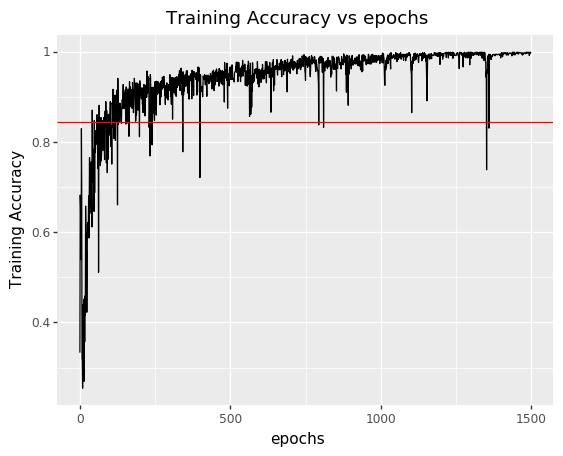

<ggplot: (8743897096801)>

In [9]:
plot_util.plot_train_acc(irm_results)

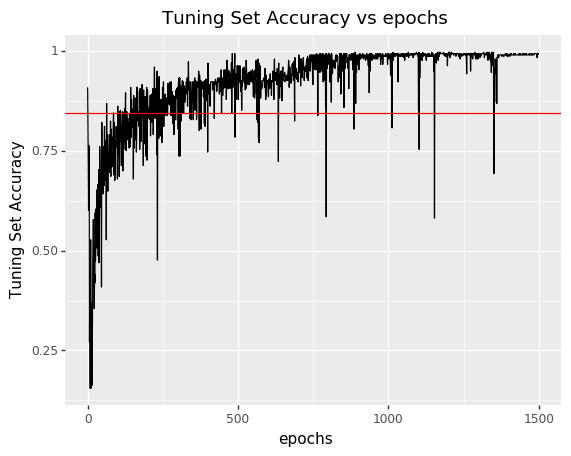

<ggplot: (8743898269461)>

In [10]:
plot_util.plot_tune_acc(irm_results)

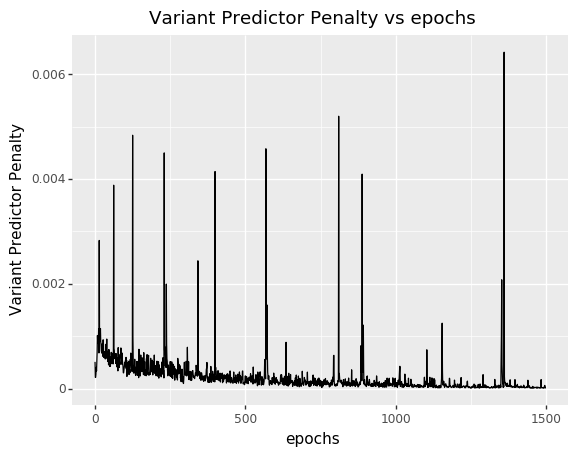

<ggplot: (8743897415401)>

In [11]:
plot_util.plot_train_penalty(irm_results)

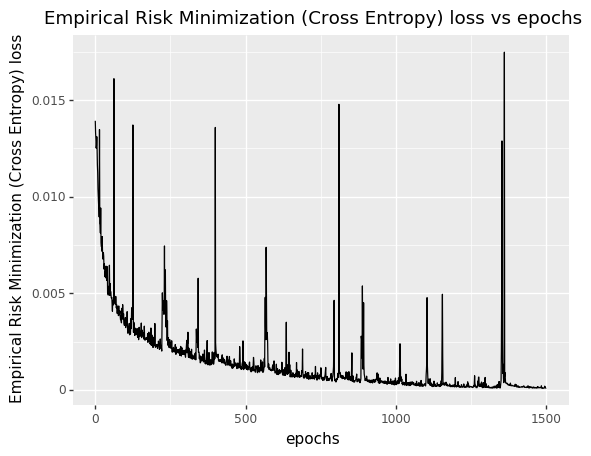

<ggplot: (8743898693497)>

In [12]:
plot_util.plot_raw_train_loss(irm_results)

In [13]:
# Train a model using empirical risk minimization (standard batch gradient descent)
erm_results = classifier.train_with_erm(net, map_file, train_dirs, tune_dirs, gene_file, num_epochs,
                                        label_to_encoding, device, logger)

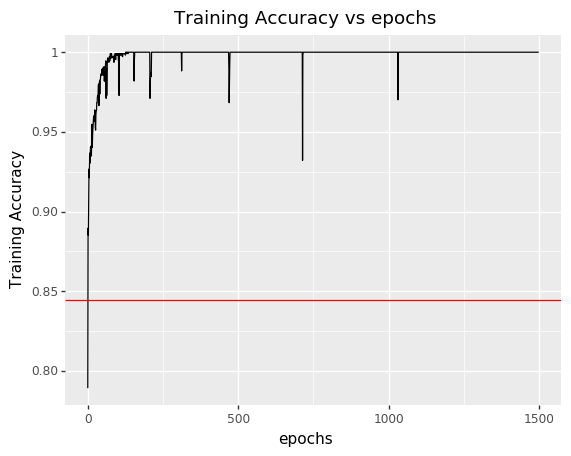

<ggplot: (8743899430037)>

In [14]:
plot_util.plot_train_acc(erm_results)

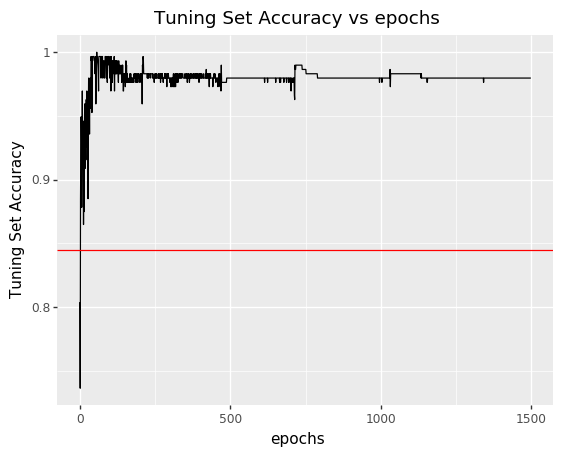

<ggplot: (8743898396581)>

In [15]:
plot_util.plot_tune_acc(erm_results)

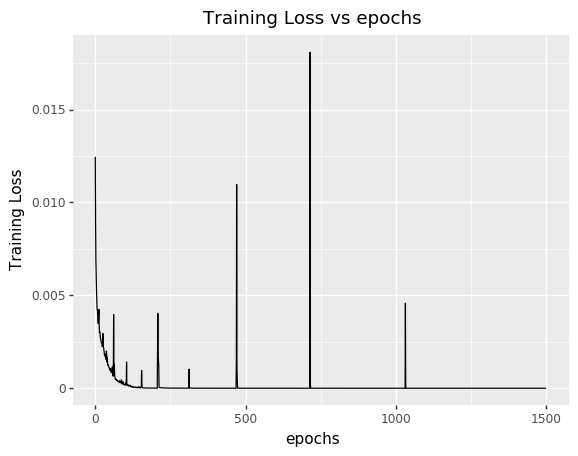

<ggplot: (8743898458109)>

In [16]:
plot_util.plot_train_loss(erm_results)

## Results

The learning curve when training normally, but the tuning set accuracy doesn't reach the same level as in IRM. We see loss spikes here as in IRM, maybe there's a misclassified sample that is ending up in a small batch or something?